In [1]:
import os
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# Ruta a la carpeta con archivos CSV en tu Drive
carpeta = '/content/drive/MyDrive/Modelos_actualizados_thermokernel_sin reacciones activas'  # Ajusta si es necesario

# Lista para guardar todos los flujos
todos_los_datos = []

for archivo in os.listdir(carpeta):
    if archivo.endswith('.csv'):
        ruta_archivo = os.path.join(carpeta, archivo)
        paciente_id = os.path.splitext(archivo)[0]

        # Leer el archivo CSV con encabezados 'Reaction' y 'Flux'
        df = pd.read_csv(ruta_archivo, sep=",", usecols=['Reaction', 'Flux'])

        # Agregar identificador de paciente
        df['paciente'] = paciente_id

        todos_los_datos.append(df)

# Combinar todos los DataFrames
df_completo = pd.concat(todos_los_datos, ignore_index=True)

# Guardar el archivo combinado
df_completo.to_csv('/content/drive/MyDrive/flujos_reacciones_unificados.csv', index=False)

print("✅ Archivo combinado guardado como 'flujos_reacciones_unificados.csv'")


MessageError: Error: credential propagation was unsuccessful

=== DBSCAN sweep eps=0.1 a 20.0 (min_samples=1) ===
eps=0.1 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=0.2 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=0.3 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=0.4 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=0.5 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=0.6 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=0.7 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=0.8 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=0.9 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=1.0 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=1.1 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=1.2 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=1.3 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=1.4 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=1.5 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=1.6 | clusters= 33 | noise=   0 | silhouette=-1.000
eps=1.7 | clusters= 33 | noise=   0 | silhouette=-1.

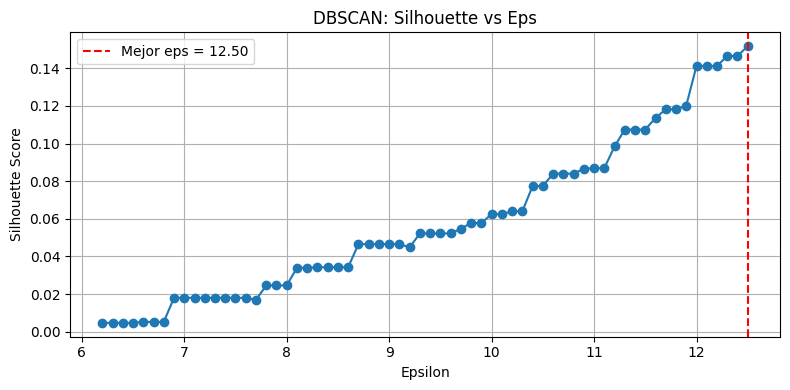

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# === 1. Cargar los datos ===
df_flujos = pd.read_csv('/content/drive/MyDrive/flujos_reacciones_unificados.csv')
df_flujos['Flux'] = pd.to_numeric(df_flujos['Flux'], errors='coerce')
df_flujos = df_flujos.dropna(subset=['Flux'])

# === 2. Pivotear ===
df_pivot = df_flujos.pivot_table(index='paciente', columns='Reaction', values='Flux')

# === 3. Imputar y escalar ===
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_pivot)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imputed)

# === 4. DBSCAN con min_samples=1 y eps extendido ===
results = []
print("=== DBSCAN sweep eps=0.1 a 20.0 (min_samples=1) ===")
for eps in np.arange(0.1, 20.1, 0.1):
    db = DBSCAN(eps=eps, min_samples=1)
    labels = db.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)

    # silhouette_score solo es válido si hay entre 2 y n_samples-1 clusters
    if 1 < n_clusters < len(X_scaled):
        score = silhouette_score(X_scaled, labels)
    else:
        score = -1

    results.append((eps, n_clusters, n_noise, score))

    if n_clusters > 1:
        print(f"eps={eps:.1f} | clusters={n_clusters:3d} | noise={n_noise:4d} | silhouette={score:.3f}")

# === 5. Mejor eps ===
valid_results = [r for r in results if r[3] > 0]
if valid_results:
    best = max(valid_results, key=lambda x: x[3])
    print(f"\n🟢 Mejor eps: {best[0]:.2f} | Clusters: {best[1]} | Silhouette: {best[3]:.3f}")

    best_db = DBSCAN(eps=best[0], min_samples=1)
    best_labels = best_db.fit_predict(X_scaled)

    df_dbscan = df_pivot.copy()
    df_dbscan['cluster'] = best_labels
    df_dbscan.to_csv('/content/drive/MyDrive/resultado_dbscan_eps20.csv')
    print("✅ Resultado DBSCAN guardado en 'resultado_dbscan_eps20.csv'")

    # Visualización
    plt.figure(figsize=(8, 4))
    eps_vals = [r[0] for r in valid_results]
    scores = [r[3] for r in valid_results]
    plt.plot(eps_vals, scores, marker='o')
    plt.axvline(best[0], color='red', linestyle='--', label=f'Mejor eps = {best[0]:.2f}')
    plt.xlabel('Epsilon')
    plt.ylabel('Silhouette Score')
    plt.title('DBSCAN: Silhouette vs Eps')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ DBSCAN aún no detecta múltiples clusters.")


In [ ]:
from sklearn.cluster import KMeans

# Usamos los mismos datos escalados que arriba
kmeans = KMeans(n_clusters=3, random_state=42)  # Ajusta el número de clusters
labels = kmeans.fit_predict(X_scaled)

df_kmeans = df_pivot.copy()
df_kmeans['cluster'] = labels
df_kmeans.to_csv('/content/drive/MyDrive/resultado_kmeans.csv')
print("✅ Clustering K-Means guardado en 'resultado_kmeans.csv'")


✅ Clustering K-Means guardado en 'resultado_kmeans.csv'


=== KMeans sweep k=2 a 20 ===
k= 2 | Silhouette Score=0.588
k= 3 | Silhouette Score=0.613
k= 4 | Silhouette Score=0.600
k= 5 | Silhouette Score=0.474
k= 6 | Silhouette Score=0.439
k= 7 | Silhouette Score=0.415
k= 8 | Silhouette Score=0.340
k= 9 | Silhouette Score=0.321
k=10 | Silhouette Score=0.298
k=11 | Silhouette Score=0.276
k=12 | Silhouette Score=0.254
k=13 | Silhouette Score=0.237
k=14 | Silhouette Score=0.255
k=15 | Silhouette Score=0.231
k=16 | Silhouette Score=0.143
k=17 | Silhouette Score=0.105
k=18 | Silhouette Score=0.130
k=19 | Silhouette Score=0.153
k=20 | Silhouette Score=0.180

🟢 Mejor k = 3 | Silhouette Score = 0.613


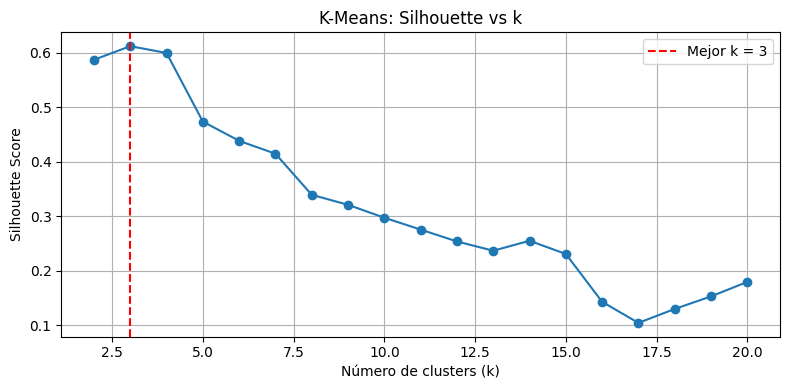

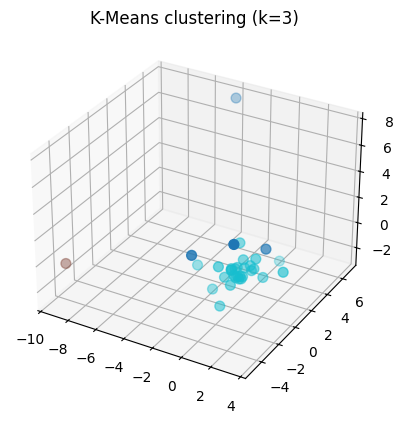

In [ ]:
# === 2. Sweep de k ===
results = []
print("=== KMeans sweep k=2 a 20 ===")
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    results.append((k, score))
    print(f"k={k:2d} | Silhouette Score={score:.3f}")

# === 3. Mejor k ===
best = max(results, key=lambda x: x[1])
print(f"\n🟢 Mejor k = {best[0]} | Silhouette Score = {best[1]:.3f}")

# === 4. Visualización del score ===
k_vals = [r[0] for r in results]
scores = [r[1] for r in results]

plt.figure(figsize=(8,4))
plt.plot(k_vals, scores, marker='o')
plt.axvline(best[0], color='red', linestyle='--', label=f'Mejor k = {best[0]}')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Means: Silhouette vs k')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 5. Visualización en 3D ===
kmeans = KMeans(n_clusters=best[0], random_state=42)
labels = kmeans.fit_predict(X_pca)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='tab10', s=50)
ax.set_title(f"K-Means clustering (k={best[0]})")
plt.show()
